In [1]:
from models.vae_nohist_glm2 import VAE_NoHist_GLM2, NN_Encoder


import numpy as np
import torch
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
V_file = "V_diff.npy"
C_syn_e_file = "handsub6_C_syn_e.npy"
C_syn_i_file = "handsub6_C_syn_i.npy"
C_den_file = "handsub6_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
V = torch.from_numpy(V)
C_den = torch.from_numpy(C_den)
sub_no = C_den.shape[0]

In [3]:
T_train = 60 * 1000 * 5
T_test = 10 * 1000 * 5
T_no = 401
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 100000
iter_no = 10000
epoch_no = 15
layer_no = 3

In [4]:
V_train = V[:T_train].to(device).float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float().to(device)
train_I_neural = I_neural[:T_train].float().to(device)
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train - batch_size))
for i in range(epoch_no):
    part_idx = np.arange(T_train - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
decoder = VAE_NoHist_GLM2(C_den, C_syn_e, C_syn_i, T_no, device)
encoder = NN_Encoder(C_syn_e, C_syn_i, T_no, layer_no, device)

enc_optimizer = torch.optim.Adam(encoder.parameters(), lr = 0.0001)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr = 0.005)

encoder.to(device).float()
decoder.to(device).float()
print(sum(p.numel() for p in encoder.parameters() if p.requires_grad))
print(sum(p.numel() for p in decoder.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="none")

12305
110


In [6]:
Z_prior = torch.ones(batch_size).to(device) * 0.0001
loss_factor = 1
temp_list = [0.5,0.4,0.3,0.2,0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.01]
temp_count = 0

true = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep10_stimseed1.npy")[:,:50000].flatten()[T_train:T_train+T_test]
old = np.load("/media/hdd01/sklee/CA1_clust4-60/alpha_sub6_output.npz")["test"]

old_score = metrics.explained_variance_score(y_true=true, y_pred=old)

for i in tnrange(iter_no):
    encoder.train()
    decoder.train()
    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()
    
    #if (i%500==0) & (temp_count < 14):
        #temp = temp_list[temp_count]
        #temp_count += 1
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size]
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size]
    batch_V = V_train[batch_idx : batch_idx+batch_size]
    
    spk_enc, Z_enc = encoder(batch_V, batch_E_neural, batch_I_neural)
    
    V_pred, Z_pred, out_filters = decoder.train_forward(batch_E_neural, batch_I_neural, spk_enc)

    prior_loss = torch.mean(bce_criterion(Z_enc , Z_prior))
    bern_loss = torch.mean( bce_criterion(Z_pred, Z_enc.detach()))
    var_loss = torch.var(batch_V - V_pred)    
    
    loss_var_exp = metrics.explained_variance_score(y_true=batch_V.cpu().detach().numpy(),
                                                      y_pred=V_pred.cpu().detach().numpy())
        
    loss = var_loss + bern_loss + prior_loss
    loss.backward()
    enc_optimizer.step()
    dec_optimizer.step()
    
    if i%250 == 249:
        test_V_pred, test_Z_pred, test_out_filters = decoder.test_forward(test_E_neural, test_I_neural)
        test_spk_enc, test_Z_enc = encoder(V_test, test_E_neural, test_I_neural)
         
        test_bern_loss = torch.mean(bce_criterion(test_Z_pred, test_Z_enc.detach()))
        
        new_score = metrics.explained_variance_score(y_true=V_test.cpu().detach().numpy(),
                                                      y_pred=test_V_pred.cpu().detach().numpy())

        
        print(i, new_score, loss_var_exp, test_bern_loss.item())


<ipython-input-6-c9b63e0932ac>:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


249 -4.457363128662109 -0.03530251979827881 0.021191740408539772
499 -1.0319905281066895 -0.04298293590545654 0.005063886754214764
749 -0.45128393173217773 -0.006308913230895996 0.0023913108743727207
999 -0.2781597375869751 -0.01467597484588623 0.0014749502297490835
1249 -0.14715123176574707 -0.011570096015930176 0.0010263677686452866
1499 -0.1626758575439453 -0.009801983833312988 0.0009375762892886996
1749 -0.05722403526306152 -0.0051697492599487305 0.0006364527507685125
1999 -0.053220510482788086 -0.0017092227935791016 0.0006152309360913932
2249 -0.027187347412109375 -0.014602303504943848 0.0004836002190131694
2499 -0.03997445106506348 -0.0031396150588989258 0.00043132109567523
2749 -0.015164732933044434 0.0 0.0003148118848912418
2999 -0.015549540519714355 -0.008036494255065918 0.0003697684733197093
3249 -0.013367056846618652 -0.0028723478317260742 0.00043556990567594767
3499 -0.008197665214538574 -0.0022971630096435547 0.0003974674909841269
3749 -0.007722139358520508 -0.015800118446

tensor(99.2564, device='cuda:0', grad_fn=<SumBackward0>)
tensor([1.5000], device='cuda:0')
Parameter containing:
tensor([1.8201], device='cuda:0', requires_grad=True)


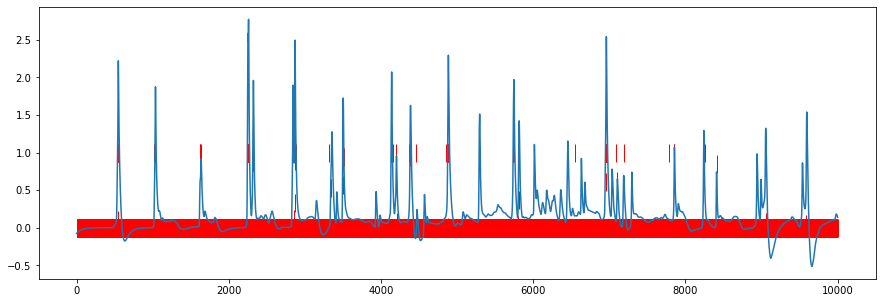

In [7]:
plt.figure(figsize=(15,5))
print(torch.sum(test_spk_enc))
print(decoder.W_spk)
print(decoder.Tau_spk)

plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.scatter(np.arange(10000),test_spk_enc.cpu().detach().numpy()[16000:26000], marker="|", s=300, linewidth=1, c="red")


In [8]:
#test_V_pred, test_Z_pred, test_out_filters = decoder.test_forward(test_E_neural, test_I_neural)
#test_spk_enc, test_Z_enc = encoder(V_test, test_E_neural, test_I_neural)
        
new = old + test_V_pred.cpu().detach().numpy()

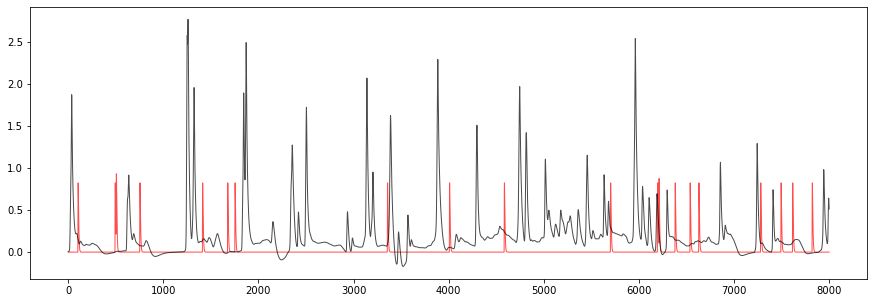

In [9]:
plt.figure(figsize=(15,5))
plt.plot(test_V_pred.cpu().detach().numpy()[17000:25000], c="red", alpha=0.7, linewidth=1)
plt.plot(V_test.cpu().detach().numpy()[17000:25000], c="black", alpha=0.7, linewidth=1)


tensor(97.1417, device='cuda:0', grad_fn=<SumBackward0>)


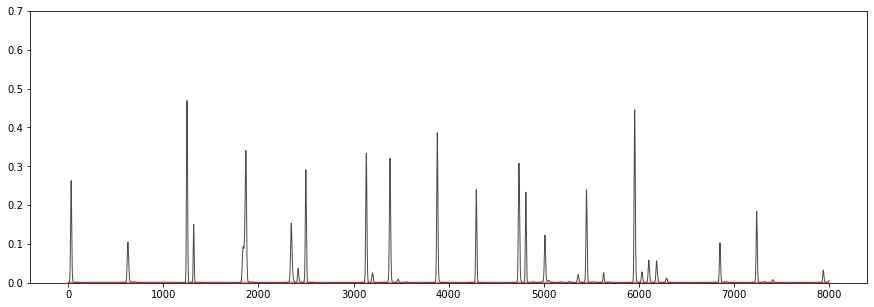

In [10]:
plt.figure(figsize=(15,5))
plt.plot(test_Z_enc[17000:25000].cpu().detach().numpy(), c="black", alpha=0.7, linewidth=1)
plt.plot(test_Z_pred[17000:25000].cpu().detach().numpy(), c="red", alpha=0.7, linewidth=1)
plt.ylim(0,0.7)
print(torch.sum(test_Z_enc))

tensor(151.6205, device='cuda:0', grad_fn=<SumBackward0>)


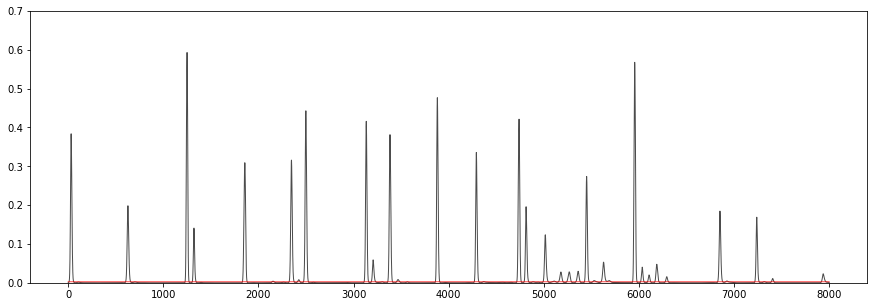

In [10]:
plt.figure(figsize=(15,5))
plt.plot(test_Z_enc[17000:25000].cpu().detach().numpy(), c="black", alpha=0.7, linewidth=1)
plt.plot(test_Z_pred[17000:25000].cpu().detach().numpy(), c="red", alpha=0.7, linewidth=1)
plt.ylim(0,0.7)
print(torch.sum(test_Z_enc))

0.9141887469103781 0.9129094389460248


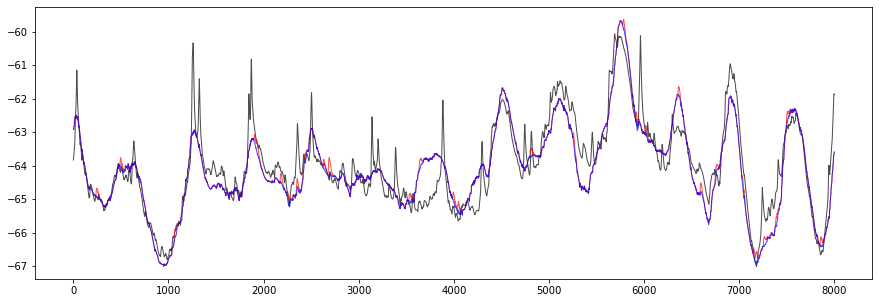

In [12]:
plt.figure(figsize=(15,5))
plt.plot(true[17000:25000], c="black", alpha=0.7, linewidth=1)
plt.plot(new[17000:25000], c="red", alpha=0.7, linewidth=1)
plt.plot(old[17000:25000], c="blue", alpha=0.7, linewidth=1)

new_score = metrics.explained_variance_score(y_true=true,
                                                      y_pred=new)
old_score = metrics.explained_variance_score(y_true=true,
                                                      y_pred=old)

print(old_score, new_score)

In [13]:
print(test_out_filters.shape)
sub_no = 6
plex_no = 3

fig, axs = plt.subplots(nrows=sub_no,ncols=plex_no, figsize=(15,15))
for row in range(sub_no):
    for col in range(plex_no):
        axs[row,col].plot(test_out_filters[row*plex_no+col].cpu().detach().numpy())
        axs[row,col].hlines(y=0,xmin=0,xmax=T_no, linewidth=1,linestyle="--")

torch.Size([24, 401])
Error in callback <function flush_figures at 0x7f51797738b0> (for post_execute):


KeyboardInterrupt: 